In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

from scipy.signal import butter, filtfilt, hilbert
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import layers, Sequential
from keras import callbacks



In [ ]:

def load_signal_and_labels(folder_path):
    # Loads signals from .mat files in the given folder.
    # Load labels from CSV
    labels_df = pd.read_csv(os.path.join('../data/REFERENCE.csv'), names=['signal_name', 'label'])
    label_map = dict(zip(labels_df['signal_name'], labels_df['label']))

    result = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.mat'):
            base = filename[:-4]
            mat_path = os.path.join(folder_path, filename)
            signal = scipy.io.loadmat(mat_path)
            # Try to get the signal array from 'val' key
            signal_array = signal['val'] if 'val' in signal else next((v for v in signal.values() if hasattr(v, 'shape')), None)
            label = label_map.get(base, None)
            result[base] = (signal_array, label)
    return result # Dictionary with filenames as keys and a tuple (signal, label) as values.
    

In [ ]:
data = load_signal_and_labels('../data/')
print(data)

In [4]:
len(data)  # Print the number of files loaded

8528

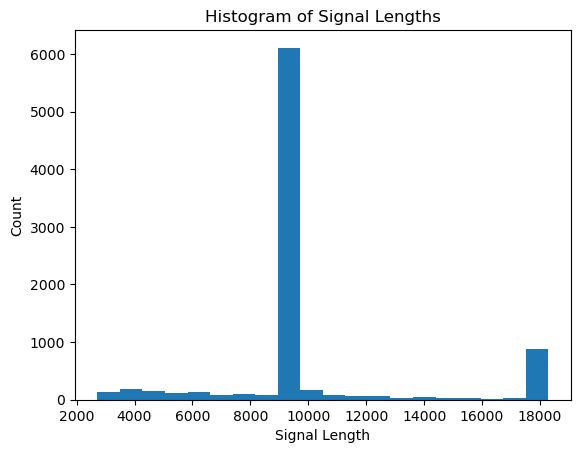

In [5]:
# Get signal lengths from the data dictionary
signal_lengths = []
for signal, _ in data.values():
    signal_lengths.append(signal.shape[1])

plt.hist(signal_lengths, bins=20)
plt.xlabel('Signal Length')
plt.ylabel('Count')
plt.title('Histogram of Signal Lengths')
plt.show()

In [6]:
labels = set(label for _, label in data.values())
print(labels)

{'O', 'N', 'A', '~'}


In [7]:
# Rename 'O' labels to 'A' and remove items with label '~'
filtered_data = {}
for key, (signal, label) in data.items():
    if label == '~':
        continue
    new_label = 'A' if label == 'O' else label
    filtered_data[key] = (signal, new_label)

# Update the labels set as well
filtered_labels = set(label for _, label in filtered_data.values())
print(filtered_labels)
# N normal A abnormal

{'N', 'A'}


In [ ]:
label_counts = Counter(label for _, label in filtered_data.values())
print(label_counts)

Counter({'N': 5050, 'A': 3194})


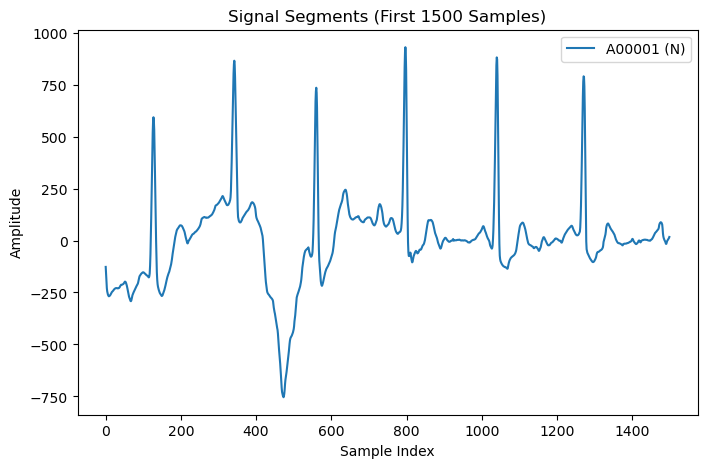

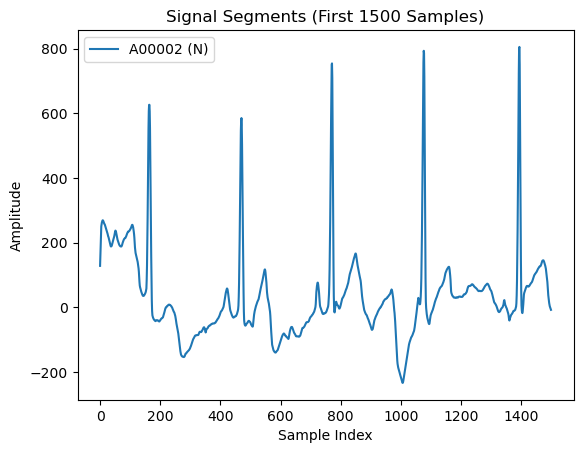

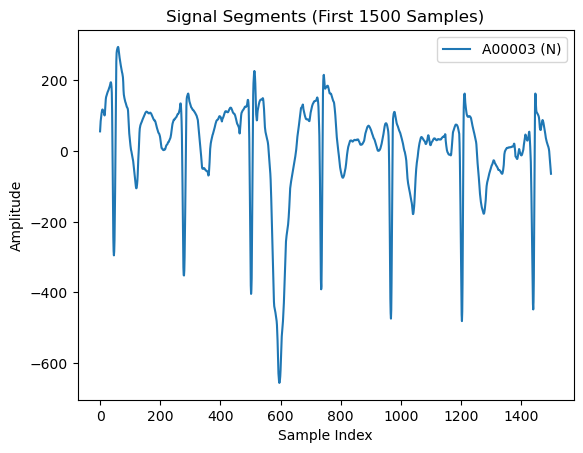

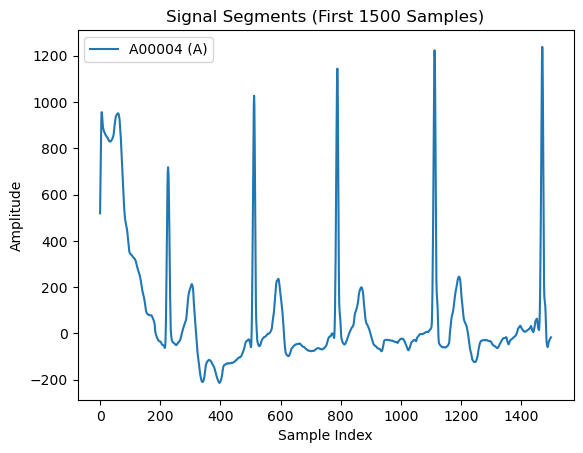

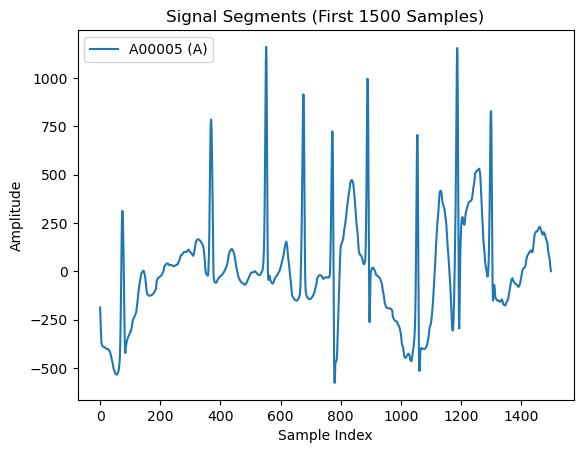

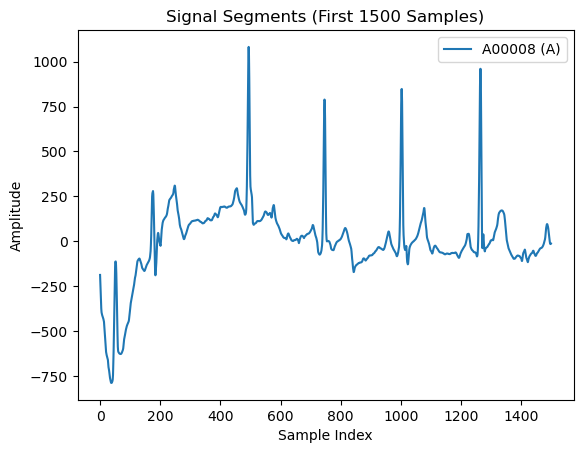

In [9]:
# Visualize a segment of signals 1, 2, 3, 4, 5, and 8 from filtered_data
segment_length = 1500  # Number of samples to plot from the start
# Find indices for the specified keys
keys_of_interest = ['A00001', 'A00002', 'A00003', 'A00004', 'A00005', 'A00008']

plt.figure(figsize=(8, 5))
for i in keys_of_interest:
    signal, label = filtered_data[i]
    plt.plot(signal[0, :segment_length], label=f'{i} ({label})')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.title(f'Signal Segments (First {segment_length} Samples)')
    plt.legend()
    plt.show()

In [ ]:

def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def compute_instantaneous_frequency(signal, fs):
    analytic_signal = hilbert(signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = np.diff(instantaneous_phase) * fs / (2.0 * np.pi)
    return instantaneous_frequency

def compute_group_delay(signal, fs):
    analytic_signal = hilbert(signal)
    phase = np.unwrap(np.angle(analytic_signal))
    freq = np.fft.fftfreq(len(signal), d=1/fs)
    phase_spectrum = np.angle(np.fft.fft(signal))
    group_delay = -np.diff(phase_spectrum) / np.diff(freq)
    return group_delay

def preprocess_and_extract_features(signals, labels, fs=500, segment_size=9000, window_size=1000, lowcut=0.5, highcut=40):
    """
    Preprocess signals and extract features for each window in each segment.
    Returns X: (samples, timesteps, features_per_timestep), y: labels.
    """
    X = []
    y = []
    for sig, lbl in zip(signals, labels):
        # Bandpass filter each channel
        filtered = np.array([bandpass_filter(ch, lowcut, highcut, fs) for ch in sig])
        num_segments = filtered.shape[1] // segment_size
        for i in range(num_segments):
            start = i * segment_size
            end = (i + 1) * segment_size
            segment = filtered[:, start:end]
            # Split segment into windows
            n_windows = segment.shape[1] // window_size
            features = []
            for w in range(n_windows):
                w_start = w * window_size
                w_end = (w + 1) * window_size
                window = segment[:, w_start:w_end]
                # Feature extraction per channel
                mean = np.mean(window, axis=1)
                std = np.std(window, axis=1)
                mean_if = [np.mean(compute_instantaneous_frequency(ch, fs)) for ch in window]
                mean_gd = [np.mean(compute_group_delay(ch, fs)) for ch in window]
                # Concatenate features for all channels
                window_features = np.concatenate([mean, std, mean_if, mean_gd])
                features.append(window_features)
            X.append(features)
            y.append(lbl)
    # one-hot encode labels
    y = np.array(y)  # shape: (samples,)
    le = LabelEncoder()
    y = le.fit_transform(y)
    # Reshape X to (samples, timesteps, features_per_timestep, 1)
    X = np.array(X)
    X = np.expand_dims(X, axis=-1)  # shape: (samples,
    return X, y




In [150]:

# Get all signals and labels from filtered_data
signals = []
labels = []
for signal, label in filtered_data.values():
    signals.append(signal)
    labels.append(label)

# Data augmentation: duplicate each signal along the time axis to double its length
signals_augmented = []
for sig, lbl in zip(signals, labels):
    concat = [sig, sig, sig] if lbl == 'A' else [sig, sig]
    sig = np.concatenate(concat, axis=1)
    signals_augmented.append(sig)

print(f"Original signals count: {len(signals)}")
print(f"Original signal shape (first): {signals[0].shape}")
print(f"Augmented signal shape (N): {signals_augmented[0].shape}")
print(f"Augmented signal shape (A): {signals_augmented[7].shape}")

# Segment signals and labels
features, flabels = preprocess_and_extract_features(signals_augmented, labels, segment_size=9000)
print(f"Features shape: {features.shape}, Labels count: {len(flabels)}")


Original signals count: 8244
Original signal shape (first): (1, 9000)
Augmented signal shape (N): (1, 18000)
Augmented signal shape (A): (1, 27000)
Features shape: (20881, 9, 4), Labels count: 20881


In [151]:
# Display new count for each label
label_counts = Counter(label for label in flabels)
print(label_counts)

Counter({0: 10554, 1: 10327})


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(features, flabels, test_size=0.2, random_state=7)   


In [162]:
print(X_train.shape, y_train.shape)  # Check shapes of training data

(16704, 9, 4, 1) (16704,)


In [ ]:
model = Sequential([
    layers.Input(shape = X_train.shape[1:]), # A 3D tensor, with shape (batch, timesteps, feature).
    layers.TimeDistributed(layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling1D(pool_size=2, padding="same")),
    layers.TimeDistributed(layers.Flatten()),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    layers.Dropout(0.7),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_104            │ (None, 9, 4, 64)       │           384 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_105            │ (None, 9, 4, 64)       │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_106            │ (None, 9, 2, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_107            │ (None, 9, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_50                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,714 (389.51 KB)

 Trainable params: 99,586 (389.01 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Visualize the model architecture
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
training = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=500, 
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[
        callbacks.TensorBoard(log_dir='../logs', histogram_freq=1, write_graph=True, write_images=True)
    ]
)

Epoch 1/100
34/34 - 2s - 72ms/step - accuracy: 0.8273 - loss: 0.3534 - val_accuracy: 0.6837 - val_loss: 0.6996
Epoch 2/100
34/34 - 2s - 66ms/step - accuracy: 0.8393 - loss: 0.3379 - val_accuracy: 0.6871 - val_loss: 0.7202
Epoch 3/100
34/34 - 2s - 68ms/step - accuracy: 0.8392 - loss: 0.3322 - val_accuracy: 0.6761 - val_loss: 0.7800
Epoch 4/100
34/34 - 2s - 69ms/step - accuracy: 0.8443 - loss: 0.3305 - val_accuracy: 0.6940 - val_loss: 0.7279
Epoch 5/100
34/34 - 3s - 75ms/step - accuracy: 0.8409 - loss: 0.3263 - val_accuracy: 0.6969 - val_loss: 0.7143
Epoch 6/100
34/34 - 2s - 72ms/step - accuracy: 0.8406 - loss: 0.3231 - val_accuracy: 0.6928 - val_loss: 0.7413
Epoch 7/100
34/34 - 2s - 73ms/step - accuracy: 0.8431 - loss: 0.3277 - val_accuracy: 0.6983 - val_loss: 0.7090
Epoch 8/100
34/34 - 3s - 74ms/step - accuracy: 0.8443 - loss: 0.3216 - val_accuracy: 0.7041 - val_loss: 0.7109
Epoch 9/100
34/34 - 3s - 74ms/step - accuracy: 0.8478 - loss: 0.3194 - val_accuracy: 0.6957 - val_loss: 0.7521
E